**1. Import Package**

In [ ]:
import pandas as pd
import numpy as np
import tweepy as tp

# Import nltk module
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Import Reguler Expression
import re

# Import textblob
from textblob import TextBlob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lemazitation
from textblob import Word

# WordCloud
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


**2. Data Understanding**

In [ ]:
# Import Data
df = pd.read_csv('/content/tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [ ]:
df.shape

(9052, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9052 entries, 0 to 9051
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      9052 non-null   int64  
 1   airline_sentiment             9052 non-null   object 
 2   airline_sentiment_confidence  9052 non-null   float64
 3   negativereason                5588 non-null   object 
 4   negativereason_confidence     6396 non-null   float64
 5   airline                       9052 non-null   object 
 6   airline_sentiment_gold        28 non-null     object 
 7   name                          9052 non-null   object 
 8   negativereason_gold           22 non-null     object 
 9   retweet_count                 9052 non-null   int64  
 10  text                          9052 non-null   object 
 11  tweet_coord                   649 non-null    object 
 12  tweet_created                 9052 non-null   object 
 13  twe

Since only the tweet data will be used, a new data frame needs to be created to save memory and improve the effectiveness of the analysis to be performed

In [ ]:
df1 =  df[['text']]
df1.head()

,text
0,@JetBlue's new CEO seeks the right balance to ...
1,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,@united yes. We waited in line for almost an h...
3,@united the we got into the gate at IAH on tim...
4,@SouthwestAir its cool that my bags take a bit...


**3. Pre-Processing**

In [ ]:
# Drop duplicate tweet
g_unique = set()
for item in df1['text']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
tweet = []
for item in g_unique:
    tweet.append(item)
    df2 = pd.DataFrame(tweet,columns = ['text'])

**3.a. Lower Casing**

In [ ]:
df2['text'] = df2['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df2['text'].head()

,text
0,@jetblue flight 1025 jfk to tpa 8:05am on satu...
1,@usairways no one is coming to line. on hold f...
2,@united i6ep18
3,@usairways on the phone over an hour waiting f...
4,@usairways we got our bags today. thanks!


**3.b. Punctuation Removal**

In [ ]:
df2['text'] = df2['text'].str.replace('[^\w\s]','')
df2.head()

,text
0,@jetblue flight 1025 jfk to tpa 8:05am on satu...
1,@usairways no one is coming to line. on hold f...
2,@united i6ep18
3,@usairways on the phone over an hour waiting f...
4,@usairways we got our bags today. thanks!


**3.c. Stopword Removal**

In [ ]:
stop = stopwords.words('english')
df2['text'] = df2['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df2['text'].head(10)

,text
0,@jetblue flight 1025 jfk tpa 8:05am saturday! ...
1,@usairways one coming line. hold 4 hours. u he...
2,@united i6ep18
3,@usairways phone hour waiting customer service...
4,@usairways got bags today. thanks!
5,"@jetblue cheated you, i'm sorry. i'll never ag..."
6,"@jetblue physically impossible make airport, f..."
7,"@usairways today,no reason 4 anyone approve me..."
8,@jetblue makes happy. hope empty promises.
9,@southwestair please help get tickets @imagine...


**3.d. Frequents Word Removal**

In [ ]:
freq = pd.Series(' '.join(df2['text']).split()).value_counts()[:10]
freq

,count
@united,2667
flight,2058
@usairways,2050
@southwestair,1804
@jetblue,1560
get,828
cancelled,641
@americanair,540
service,432
i'm,427


**3.e. Rare Words Removal**

In [ ]:
rare_word = pd.Series(' '.join(df2['text']).split()).value_counts()[-10:]
rare_word

,count
#passengerslose,1
@robbogart,1
fib,1
#twitterhug,1
#shesaidrun,1
"swamped,",1
au,1
"prince,",1
on-going,1
2morrw,1


In [ ]:
rare_word = list(rare_word.index)
df2['text'] = df2['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df2['text'].head()

,text
0,1025 jfk tpa 8:05am saturday! one way ticket!
1,one coming line. hold 4 hours. u help provide ...
2,i6ep18
3,phone hour waiting customer got wrong fight in...
4,got bags today. thanks!


**3.f. Spelling Correction**

In [ ]:
#Spelling correction
df2['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

,text
0,1025 of tea 8:am saturday! one way ticket!
1,one coming line. hold 4 hours. u help provide ...
2,i6ep18
3,phone hour waiting customer got wrong fight in...
4,got bags today. thanks!


**3.g. Tokenization**

In [ ]:
TextBlob(df2['text'][1]).words

WordList(['one', 'coming', 'line', 'hold', '4', 'hours', 'u', 'help', 'provide', 'conf', 'code'])

**3.h. Stemming**

In [ ]:
st = PorterStemmer()
df2['text'] = df2['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

**3.f. Lemazitation**

In [ ]:
df2['text'] = df2['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df2['text'].head()

,text
0,1025 jfk tpa 8:05am saturday! one way ticket!
1,one come line. hold 4 hours. u help provid con...
2,i6ep18
3,phone hour wait custom got wrong fight inform ...
4,got bag today. thanks!


**4.Data exploration**

In [ ]:
cs = df['airline_sentiment'].value_counts()
cs

,count
airline_sentiment,
negative,9082
neutral,3069
positive,2334


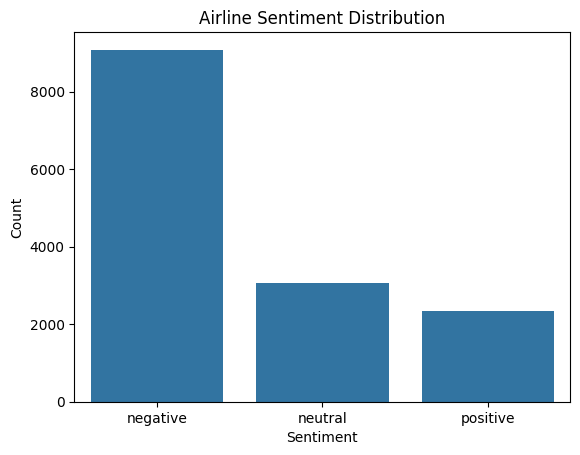

In [ ]:
cs = df['airline_sentiment'].value_counts()
cs
sns.barplot(x=cs.index, y=cs.values)
# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Airline Sentiment Distribution')

# Display the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

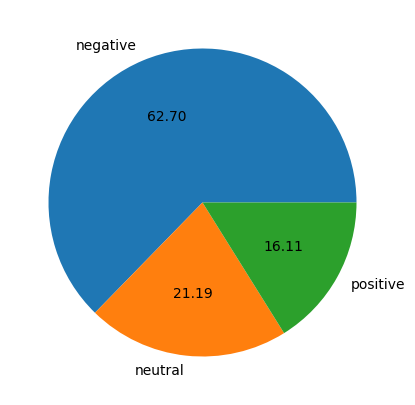

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(cs, labels=cs.index, autopct='%.2f')
plt.show

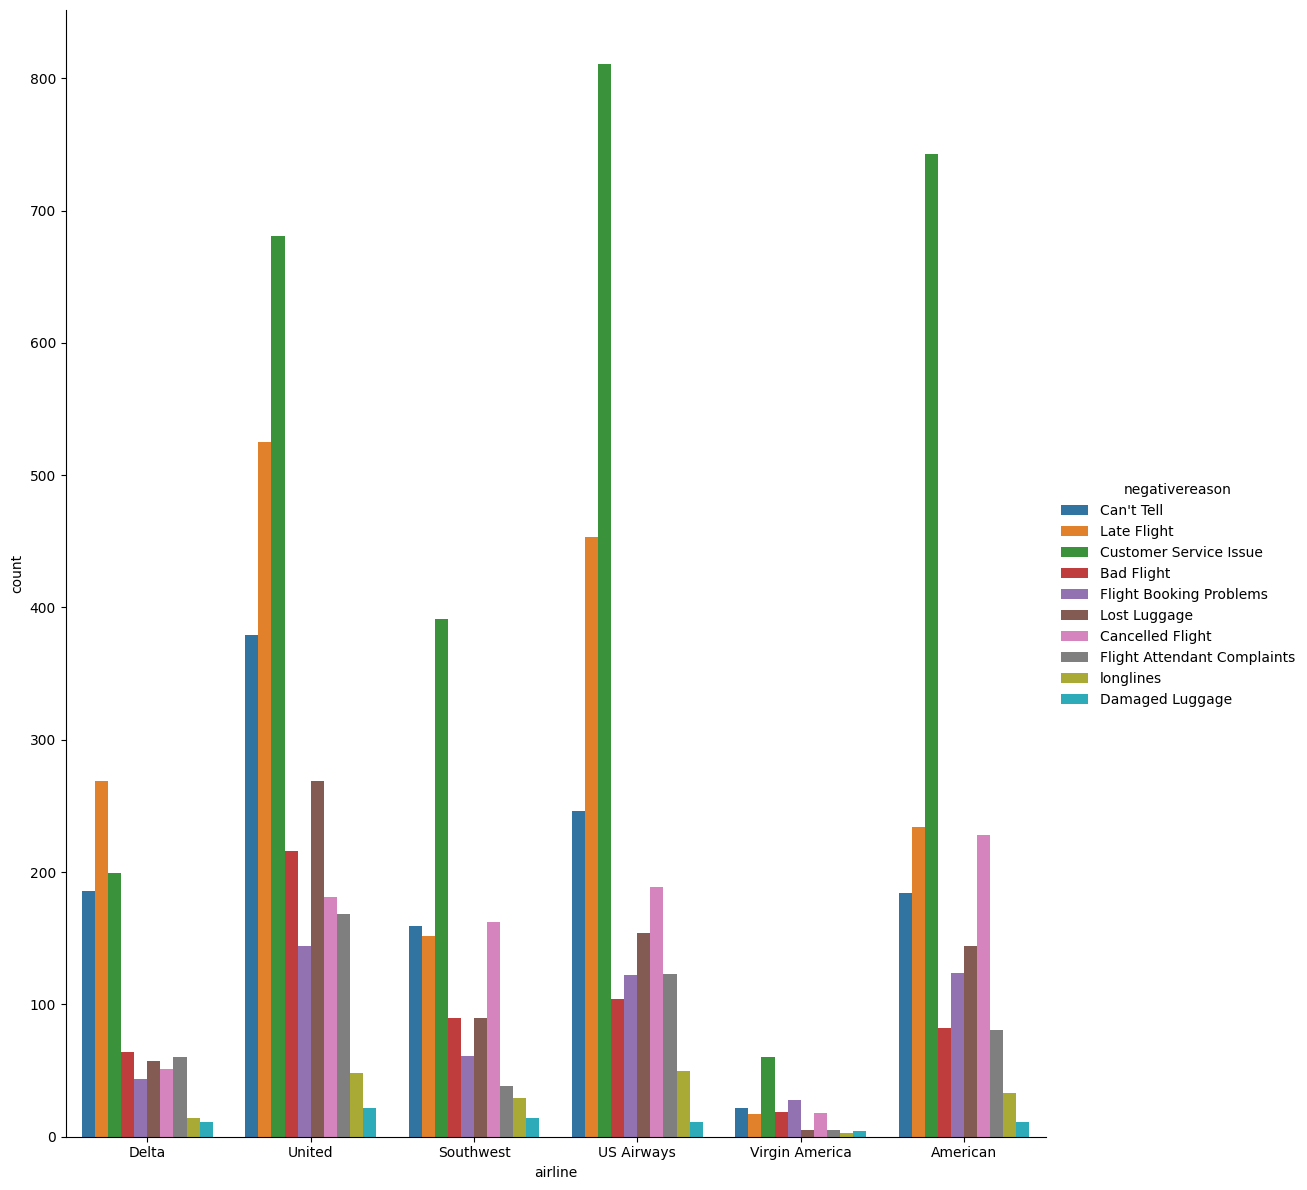

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replacing factorplot with catplot
sns.catplot(x='airline', data=df, kind='count', hue='negativereason', height=12, aspect=.9)

# Showing the plot
plt.show()

**5. Sentiment Analysis**

In [ ]:
wordc = "".join(df2.text.values)

In [ ]:
#make a wordcloud
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

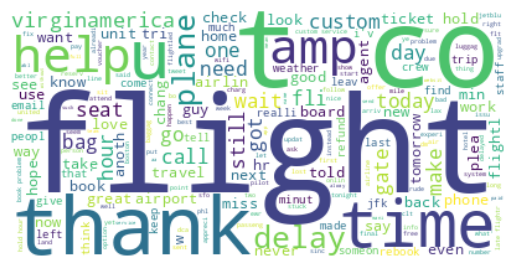

In [ ]:
create_word_cloud(wordc)

**WordCloud Sentiment Positive, Negative, Neutral**

In [ ]:
# positive = df.loc[df['airline_sentiment'] == "positive"]
negative  = df.loc[df['airline_sentiment'] == "negative"]
# neutral  = df.loc[df['airline_sentiment'] == "neutral"]

In [ ]:
# positive = "".join(positive.positivereason.values)
negative = "".join(negative.negativereason.values)
# neutral = "".join(neutral.neutralreason.values)

In [ ]:
#make a wordcloud
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

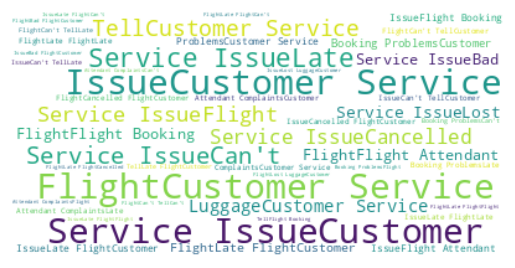

In [ ]:
create_word_cloud(negative)